#Importing necessary libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler # creating duplicate values of the less column values
from sklearn.preprocessing import StandardScaler #scale the values by average value and mean value
#neural network
import tensorflow as tf
#classification report
from sklearn.metrics import classification_report

#Reading dataframe

In [52]:
# Load and preprocess data
columns_names = ["age",	"sex",	"cp",	"trestbps", "chol",	"fbs",	"restecg",	"thalach",	"exang",	"oldpeak",	"slope",	"ca",	"thal", "target"]
data_frame = pd.read_csv("/content/Heart_Attack_Data_Set.csv")
data_frame.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#Finding and replacing unique classes in the dataset

In [53]:
data_frame["target"].unique()
#1 means death
#0 means alive

array([1, 0])

#Ploting histogram for each class to find out the difference

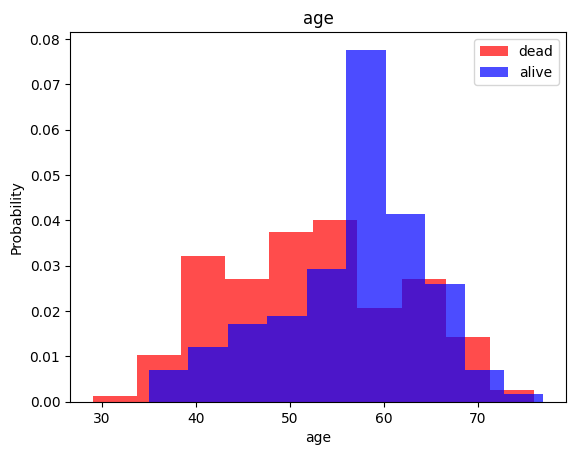

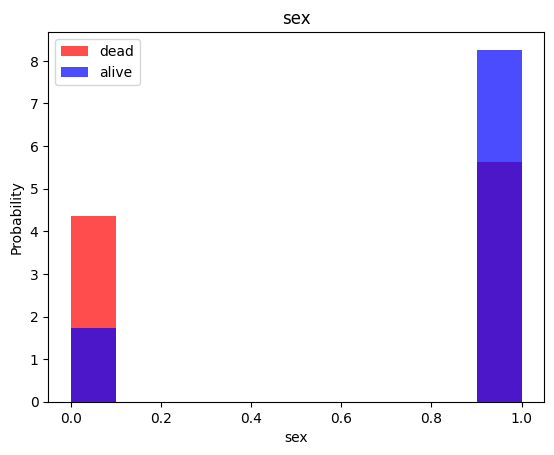

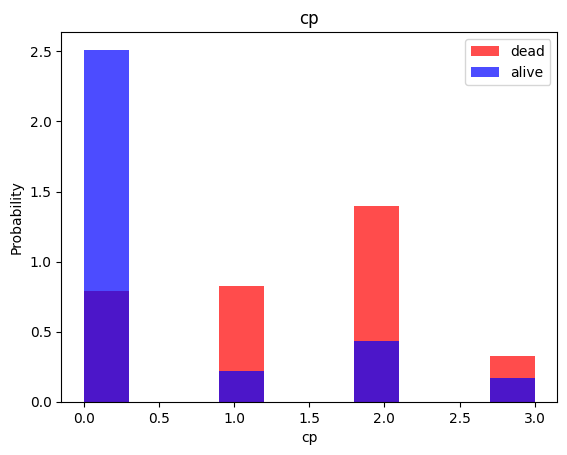

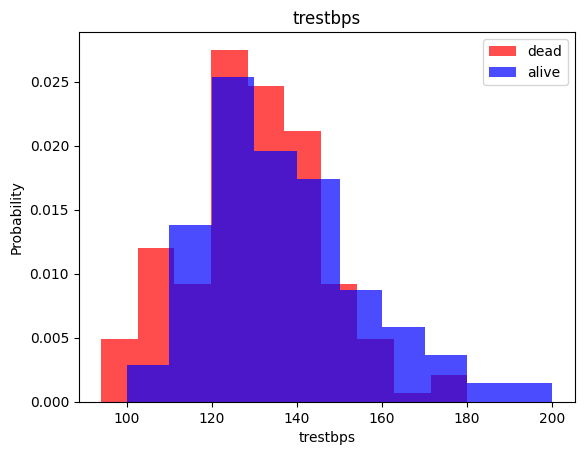

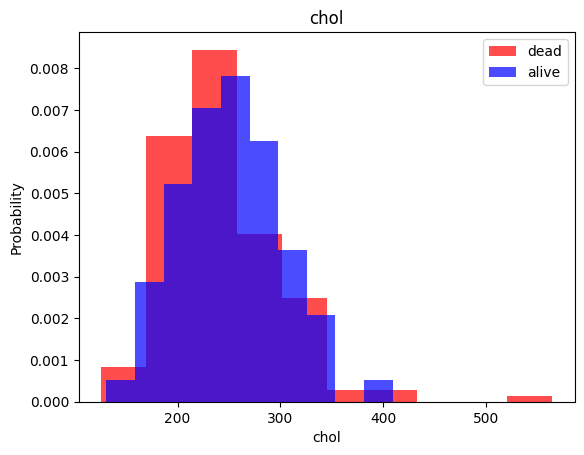

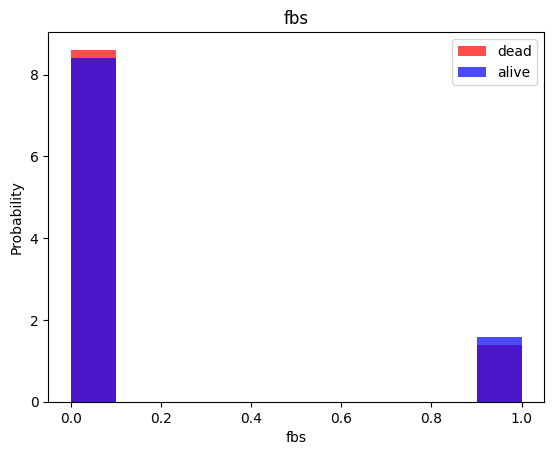

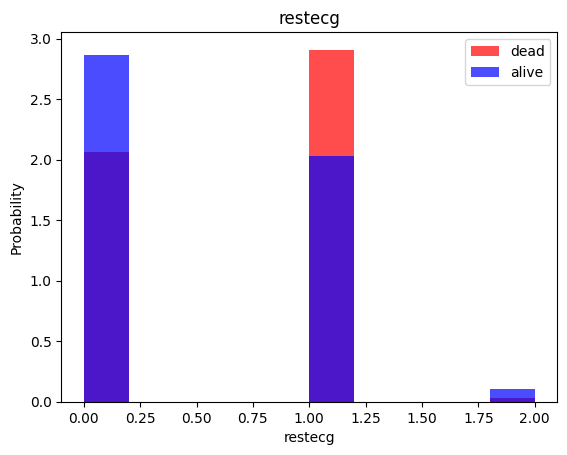

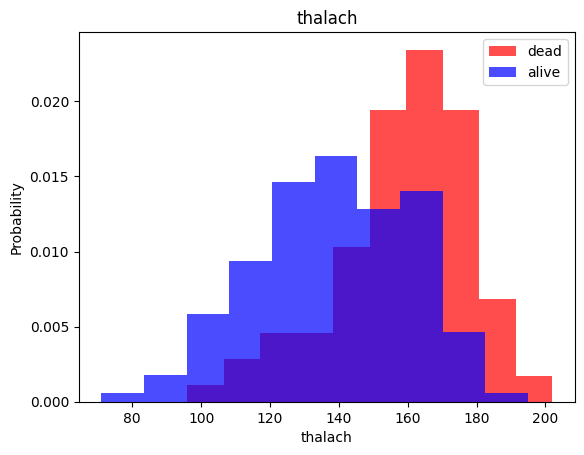

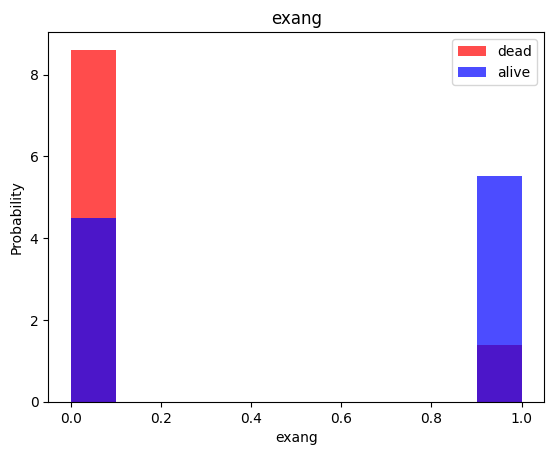

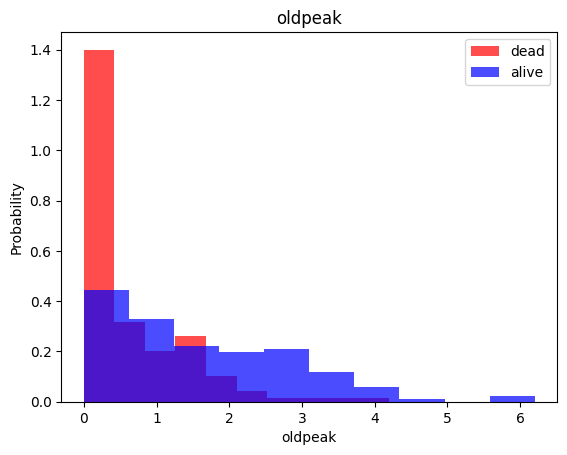

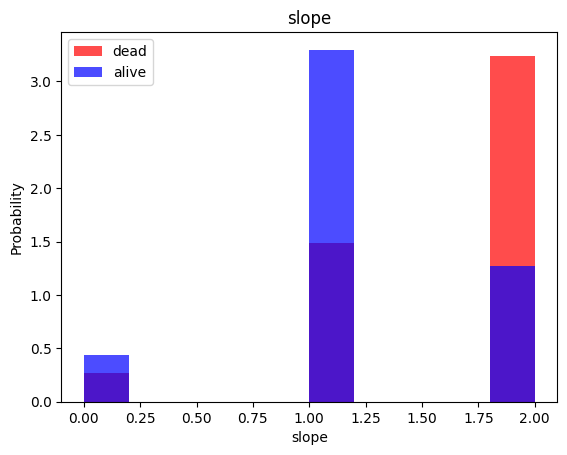

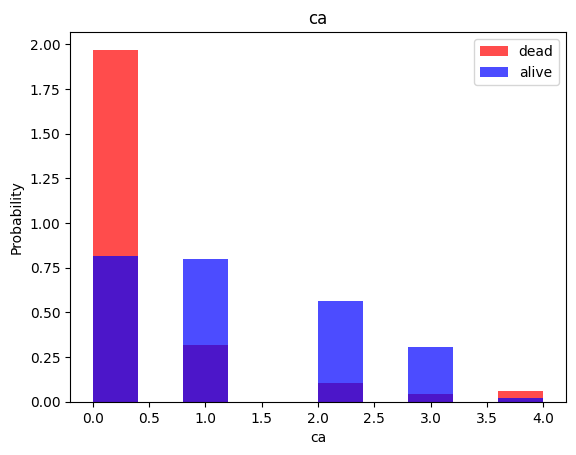

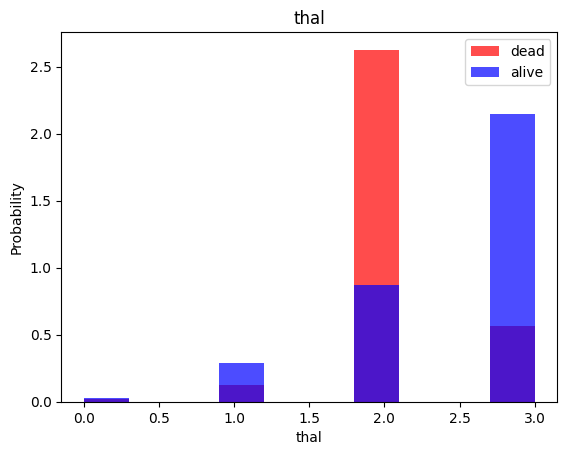

In [54]:
for label in columns_names[:-1]:
  plt.hist(data_frame[data_frame["target"] == 1][label], color="red", alpha=0.7, label = "dead", density = True)
  plt.hist(data_frame[data_frame["target"] == 0][label], color="blue", alpha=0.7, label = "alive", density = True)

  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

#Spliting data into train, validation, and test

In [55]:
train, val, test = np.split(data_frame.sample(frac=1), [int(0.6*len(data_frame)), int(0.8*len(data_frame))])
print(train.head())
print(val.head())
print(test.head())

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
296   63    0   0       124   197    0        1      136      1      0.0   
135   49    0   0       130   269    0        1      163      0      0.0   
214   56    1   0       125   249    1        0      144      1      1.2   
19    69    0   3       140   239    0        1      151      0      1.8   
245   48    1   0       124   274    0        0      166      0      0.5   

     slope  ca  thal  target  
296      1   0     2       0  
135      2   0     2       1  
214      1   1     2       0  
19       2   2     2       1  
245      1   0     3       0  
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
44    39    1   2       140   321    0        0      182      0      0.0   
265   66    1   0       112   212    0        0      132      1      0.1   
114   55    1   1       130   262    0        1      155      0      0.0   
283   40    1   0       152   223    0        1      

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


#Get XY splits

In [56]:
def scale_dataset(dataframe, over_sample = False):
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(x)

  if over_sample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [57]:
train_data, x_train, y_train = scale_dataset(train)
val_data, x_val, y_val = scale_dataset(val)
test_data, x_test, y_test = scale_dataset(test)
print(x_train)

[[ 0.97781792 -1.47493681 -0.98459094 ... -0.6092718  -0.69324281
  -0.48083096]
 [-0.59239159 -1.47493681 -0.98459094 ...  0.96613099 -0.69324281
  -0.48083096]
 [ 0.19271316  0.67799515 -0.98459094 ... -0.6092718   0.37920974
  -0.48083096]
 ...
 [ 0.52918663  0.67799515 -0.98459094 ... -2.18467458 -0.69324281
   1.10154001]
 [-1.1531807   0.67799515 -0.98459094 ... -2.18467458 -0.69324281
  -2.06320193]
 [ 0.08055534 -1.47493681 -0.01605311 ...  0.96613099 -0.69324281
  -0.48083096]]


# Ploting Loss and accuracy

In [58]:

def plot_loss(history):
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Binary crossentropy")
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid(True)
  plt.show()

#Build and Training neural network

In [59]:
def build_and_train_nn(x_train, y_train, learning_rate=0.001, epochs=100, batch_size=16, dropout_prob=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", input_shape=(13,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation="sigmoid") # output layer
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=["accuracy"]
    )
    history = model.fit(
        x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1
    )
    return model, history


Epoch 1/1000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5629 - loss: 0.7781 - val_accuracy: 0.8378 - val_loss: 0.4970
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7318 - loss: 0.5788 - val_accuracy: 0.8919 - val_loss: 0.3988
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7303 - loss: 0.5145 - val_accuracy: 0.8649 - val_loss: 0.3624
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7923 - loss: 0.4606 - val_accuracy: 0.8649 - val_loss: 0.3487
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7888 - loss: 0.4662 - val_accuracy: 0.8649 - val_loss: 0.3359
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8305 - loss: 0.4144 - val_accuracy: 0.8649 - val_loss: 0.3285
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8244 - loss: 0.4307 - val_accuracy: 0.8649 - val_loss: 0.3234
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8036 - loss: 0.4120 - val_accuracy: 0.8649 - val_loss: 0.3

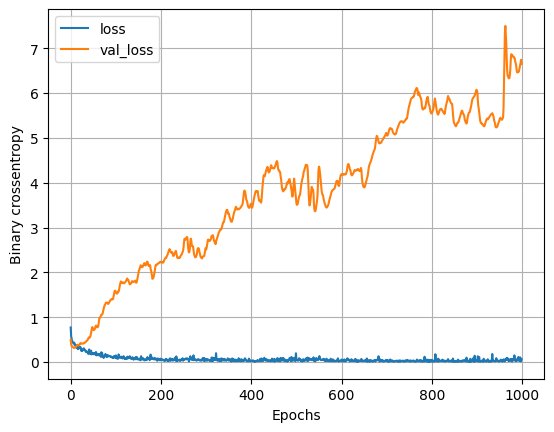

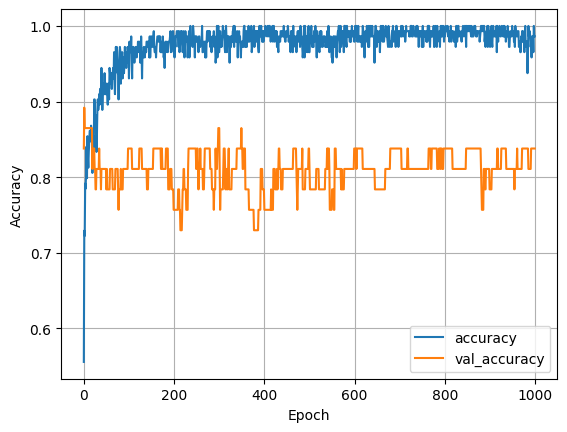

In [60]:
neural_network, history = build_and_train_nn(x_train, y_train, 0.01, 1000, 64, 0.3)
plot_loss(history)
plot_accuracy(history)

# Make predictions on test set

In [61]:
predict = neural_network.predict(x_test)
predict = (predict > 0.5).astype(int)
print(classification_report(y_test, predict))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        27
           1       0.78      0.85      0.82        34

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61

